<a href="https://colab.research.google.com/github/meihuno/ml_practice/blob/main/%E7%8B%AC%E5%A5%B3%E9%80%9A%E4%BF%A1%E3%82%92%E7%B5%B6%E5%AF%BE%E6%A4%9C%E5%87%BA%E3%81%99%E3%82%8B%E3%83%9E%E3%82%B7%E3%83%BC%E3%83%B32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pythonによる機械学習モデル構築の練習。

複数の手法によるテキスト分類精度を確認します。処理の流れは以下です。

1. データロード
2. 単語区切り、日本語（Mecab)
3. 単語頻度によるベクトルを作る
4. 交差検定用のデータ分割

以下は手法ごとに回していきます。

5. 交差検定データごとに、最善のパラメータ探索
6. confusion matrix 表示
7. PR曲線を描きます。

各手法でのRecall100時のPrecisionはいくらかな？を比較がしたい。

# Mecabの準備

In [2]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3
!ln -s /etc/mecabrc /usr/local/etc/mecabrc

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [3]:
# Mecab 動作確認
import MeCab
tagger = MeCab.Tagger()
print(tagger.parse('フシギダネは不思議だね。'))

フシギダネ	名詞,一般,*,*,*,*,*
は	助詞,係助詞,*,*,*,*,は,ハ,ワ
不思議	名詞,形容動詞語幹,*,*,*,*,不思議,フシギ,フシギ
だ	助動詞,*,*,*,特殊・ダ,基本形,だ,ダ,ダ
ね	助詞,終助詞,*,*,*,*,ね,ネ,ネ
。	記号,句点,*,*,*,*,。,。,。
EOS



# データの準備

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import json

# json_open = open('./sample_data/sample2.json', 'r')
json_open = open('/content/drive/My Drive/ldcc.json', 'r')
json_load = json.load(json_open)  

print(len(json_load))

7376


# pip ライブラリの準備

In [5]:
!pip install -q transformers[tf,torch,sentencepiece,vision,optuna,sklearn,onnxruntime]==4.11.3

     |████████████████████████████████| 2.9 MB 4.9 MB/s 
     |████████████████████████████████| 880 kB 60.0 MB/s 
     |████████████████████████████████| 3.3 MB 51.9 MB/s 
     |████████████████████████████████| 120 kB 53.0 MB/s 
     |████████████████████████████████| 96 kB 7.1 MB/s 
     |████████████████████████████████| 83 kB 2.5 MB/s 
     |████████████████████████████████| 212 kB 77.4 MB/s 
     |████████████████████████████████| 4.9 MB 30.5 MB/s 
     |████████████████████████████████| 1.3 MB 64.9 MB/s 
     |████████████████████████████████| 348 kB 77.7 MB/s 
     |████████████████████████████████| 46 kB 3.8 MB/s 
     |████████████████████████████████| 13.1 MB 66.5 MB/s 
     |████████████████████████████████| 99 kB 11.8 MB/s 
     |████████████████████████████████| 55 kB 3.9 MB/s 
     |████████████████████████████████| 86 kB 5.9 MB/s 
     |████████████████████████████████| 87 kB 7.7 MB/s 
     |████████████████████████████████| 81 kB 11.3 MB/s 
     |██████████████████████

In [6]:
!pip install datasets[audio]==1.16.1
# 東北大版のBERTに必要
!pip install fugashi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 298 kB 4.9 MB/s 
     |████████████████████████████████| 115 kB 52.6 MB/s 
     |████████████████████████████████| 212 kB 53.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 568 kB 4.9 MB/s 


In [7]:
import MeCab
from tqdm import tqdm, tqdm_pandas, tqdm_notebook
from tqdm.notebook import tqdm_notebook

import numpy as np
import pandas as pd
from pandas import json_normalize

df = json_normalize(json_load) #Results contain the required data
df.dropna(inplace=True)

def get_wakati_text(text) -> None:
  tagger = MeCab.Tagger("-Owakati")
  wakati_text = tagger.parse(text).strip()
  return wakati_text

# tqdm_notebook.pandas(desc='mecab progress: ')
# df['wakati_text'] = df.text.progress_apply(get_wakati_text)

def convert_to_num_label(label):
  if label == 'dokujo-tsushin':
    return 1
  else:
    return -1

def shorten_text(text):
  if len(text) > 300:
    return text[0:299]
  else:
    return text

def convert_to_num_label2(label):
  if label == 'dokujo-tsushin':
    return 1
  else:
    return 0

tqdm_notebook.pandas(desc='shorten progress: ')
df['short_text'] = df.text.progress_apply(shorten_text)

tqdm_notebook.pandas(desc='label change progress: ')
df['label'] = df.cls.progress_apply(convert_to_num_label2)
print(df['label'])

shorten progress:   0%|          | 0/7376 [00:00<?, ?it/s]

label change progress:   0%|          | 0/7376 [00:00<?, ?it/s]

0       0
1       0
2       0
3       0
4       0
       ..
7371    0
7372    0
7373    0
7374    0
7375    0
Name: label, Length: 7376, dtype: int64


In [8]:
s = df['label']
print([(s == 0).sum(), (s == 1).sum()])

[6505, 871]


In [9]:
from datasets import load_dataset
from datasets import Dataset
# data_list = load_dataset("json", data_files = '/content/drive/My Drive/ldcc.json')
doc_dict = {}
doc_dict['data'] = json_load
data_list = Dataset.from_dict(doc_dict)
print(data_list[0])

{'data': {'cls': 'movie-enter', 'text': '2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。八日目の蝉妻子ある男と愛し合い、その子を身ごもりながら、あきらめざるをえなかった女。彼女は同時に、男の妻が子供を産んだことを知る。その赤ん坊を見に行った女は、突発的にその子を連れ去り、逃避行を続けた挙句、小豆島に落ち着き、母と娘として暮らしはじめる。不倫相手の子供を誘拐し、4年間育てた女永作博美が演じる野々宮希和子は、不倫相手の子を宿しながらも、彼の「いずれ妻と別れるから、それまで待ってくれ」という常套句を信じて、中絶。後遺症により、二度と子供を産めない身体となってしまいます。その後、不倫相手から彼の妻が出産したことを知らされ、別れを決意。最後に諦めをつけるため、彼らの生後6ヶ月の赤ん坊・恵理菜の顔を見た希和子でしたが、自分に笑顔で向けた恵理菜を見て、思わず誘拐。名前を変えて恵理菜を薫と名付けると、人目を避けて各地を転々とし、二人で幸せな時間を過ごしますが、辿り着いた最後の場所・小豆島で4年の逃避行に終止符を打ちます。誘拐犯に育てられた女4歳になって実の両親と再会を果たした後も、世間から言われの無い中傷を受け、本当の両親との関係を築けないまま、21歳の大学生へと成長した恵理菜。過去と向き合うことを避けてきた恵理菜でしたが、劇団ひとりが演じる不倫相手・岸田孝史の子を宿し、ずっと憎み続けてきた希和子と同じ道を歩んでいることに気付いた彼女は、小池栄子が演じるルポライター・安藤千草と共に、4年間の逃亡生活を追憶する旅に出ます。希和子との幸せだった時間に触れながら、最終地・小豆島に辿り着いた恵理菜が見た真実とは？八日目の蝉は幸せなのだろうか？蝉は俗説として、一生の大半を幼虫として地下で費やし、地上に出て羽化からわずか1週間程度で死ぬと言われています。八日目まで生き残ってしまった蝉が目にしたのは、孤独か、あるいは誰も目にすることのできなかった世界なのでしょうか。中絶に

# 学習データと正解ラベルの配列を作成する

Xとyである。

# 事前学習モデルのためのtokenizeとtoken_id化

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pprint as pp
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

import pandas as pd
import torch

from transformers import BertTokenizer, BertForSequenceClassification, pipeline
from transformers import AdamW
from transformers import BertJapaneseTokenizer

# model_name = "cl-tohoku/bert-large-japanese"
model_name = "cl-tohoku/bert-base-japanese-v2"
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
tokenizer = BertTokenizer.from_pretrained(model_name)

sentences = df.short_text.values

# 最大トークン数の確認
max_len = 0
count = 0
# 1文づつ処理
for sentence in sentences:
    # Tokenizeで分割
    token_words = tokenizer.tokenize(sentence)
    # 文章数を取得してリストへ格納
    if count < 10:
      print(sentence)
      # print(token_words)
    count += 1
    # if len(sentence) > max_len:
    if len(token_words) > max_len:
        max_len = len(token_words)
print(max_len)


Downloading:   0%|          | 0.00/517 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/427M [00:00<?, ?B/s]

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-v2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification wer

Downloading:   0%|          | 0.00/230k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/174 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertJapaneseTokenizer'. 
The class this function is called from is 'BertTokenizer'.


2005年11月から翌2006年7月まで読売新聞にて連載された、直木賞作家・角田光代による初の長編サスペンス『八日目の蝉』。2010年に檀れいと北乃きいの出演によりテレビドラマ化された同作が、2011年4月に永作博美と井上真央の出演によって映画化。そして、劇場公開から半年が過ぎた10月28日、DVD＆ブルーレイとなって発売されました。八日目の蝉妻子ある男と愛し合い、その子を身ごもりながら、あきらめざるをえなかった女。彼女は同時に、男の妻が子供を産んだことを知る。その赤ん坊を見に行った女は、突発的にその子を連れ去り、逃避行を続けた挙句、小豆島に落ち着き、母と娘として暮らしはじめる。不倫相手の子
「アンテナを張りながら生活をしていけばいい」2月28日、映画『おかえり、はやぶさ』（3月10日より公開）と文部科学省とのタイアップとして、千代田区立神田一橋中学校に通う中学三年生と“宇宙”をテーマにした特別授業を行った。本作で主演を務める藤原竜也がサプライズで登場し、イベントを盛り上げた。イベントの挨拶で奥村展三文部科学副大臣は「みなさんは大きな夢を持っているということで、実現するために、文部科学省も環境を作り応援していますので、チャレンジ精神で頑張ってください。」と参加した生徒たちにエールを送った。今回の特別授業は、2部制で行われた。第1部では、ロケットの中はどうなっているのか、発射した時
3月2日より全国ロードショーとなる、スティーブン・スピルバーグの待望の監督最新作『戦火の馬』。早くもアカデミー賞最有力候補として大きな注目を集めている同作のロンドンロイヤル・プレミアが、現地時間8日（日本時間9日未明）に行われた。本プレミアは、英国王室ウィリアム王子とハリー王子が運営する慈善団体のチャリティイベントとして開催され、会場には昨年4月にロイヤル・ウェディングを挙げたウィリアム王子とキャサリン妃も出席。結婚後、初の映画プレミア公式出席に会場のレスタースクエアは、ファンの大歓声に包まれた。『戦火の馬』は、第一次大戦を舞台に、悲劇に見舞われながらも希望を信じて生き抜く人間たちの姿を、ジ
女優の香里奈が18日、都内で行われた映画『ガール』（5月26日公開）の女子高生限定試写会にサプライズで出席し、約100人の女子高生からのガチンコ質問に答えた。・映画『ガール』特集−ナノケアが当たるキャ

# データの分割。train、validate、test

In [12]:
X1 = df
y1 = df['label']

X_train1, Xdf_test, y_train1, ydf_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
Xdf_train, Xdf_validate, ydf_train, ydf_validate = train_test_split(X_train1, y_train1, test_size=0.2, random_state=0)
print([Xdf_train.shape, Xdf_validate.shape, Xdf_test.shape])

[(4720, 5), (1180, 5), (1476, 5)]


In [13]:
train_docs = Xdf_train["short_text"].tolist()
train_labels = ydf_train.tolist()

validate_docs = Xdf_validate["short_text"].tolist()
validate_labels = ydf_validate.tolist()
len(validate_docs)

test_docs = Xdf_test["short_text"].tolist()
test_labels = ydf_test.tolist()
print([len(train_docs), len(validate_docs), len(test_docs)])

print(train_docs[0:2])

[4720, 1180, 1476]
['7日、日産スタジアムで国際親善試合＝チェコ戦を戦った日本代表は、1日のペルー戦前半と同じ3-4-3の新システムで臨むと、前回の試合以上にスムーズな試合運びをみせたが、決定機をものにできず、2試合連続のスコアレスドローに終わった。同夜、日本テレビ「NEWSZERO」では、サッカー解説者で元日本代表の北澤豪氏が試合を振り返った。「結果だけを見ると、勝っていませんし、どっちかというと日本より格下の相手ですから、いいとはいえないですよね」と切り出した北澤氏は「ただ、個人的にはこの新しいシステム、3-4-3、やめる必要は全くないと思いますね。ペルー戦よりも今日のチェコ戦の方が格段にシステムを理解してい', 'Peachyアプリを利用している皆さま、アプリの「お気に入り」機能は使っていますか？「お気に入り」とは、「あとでまた読みたい！」と思った記事を登録すると、読みたいときにいつでもその記事を呼び出せちゃう便利な機能です。つまり、「お気に入り」の数が多いほど、読者の関心をひいた記事ということ。それでは、先週（2012年5月24日〜5月30日）最も多く「お気に入り」登録された記事TOP5をご紹介します！第1位：こんな使い道アリ!?シャンプーの超意外な活用方法3つ良さそうだと思って買ったけど、「香りが好きじゃない」「頭皮や髪質に合わなかった」などの理由で使いきらずに残っているシャンプーはありませんか？']


# 東北大 Bertのfine-tuning

In [14]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"
device

'cuda:0'

In [15]:
print(len(train_docs))

4720


In [16]:
# model_name = "cl-tohoku/bert-large-japanese"
model_name = "cl-tohoku/bert-base-japanese-v2"

# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)
model = model.to(device)
# tokenizer = BertTokenizer.from_pretrained(model_name)

train_encodings = tokenizer(train_docs, return_tensors='pt', padding=True, truncation=True, max_length=281).to(device)
validate_encodings = tokenizer(validate_docs, return_tensors='pt', padding=True, truncation=True, max_length=281).to(device)
test_encodings = tokenizer(test_docs, return_tensors='pt', padding=True, truncation=True, max_length=281).to(device)
# train_encodings = tokenizer(train_docs, return_tensors='pt', padding=True, truncation=True, max_length=128).to(device)
# print(train_encodings)
print(len(train_encodings))

3


In [17]:

import torch

class JpSentiDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = JpSentiDataset(train_encodings, train_labels)
validate_dataset = JpSentiDataset(validate_encodings, validate_labels)
test_dataset = JpSentiDataset(test_encodings, test_labels)

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted', zero_division=0)
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,             # total number of training epochs
    learning_rate = 2e-5,             # learning rate
    per_device_train_batch_size=4,  # batch size per device during training
    per_device_eval_batch_size=8,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    save_total_limit=1,              # limit the total amount of checkpoints. Deletes the older checkpoints.
    dataloader_pin_memory=False,  # Whether you want to pin memory in data loaders or not. Will default to True
    # evaluation_strategy="epoch",     # Evaluation is done at the end of each epoch.
    evaluation_strategy="steps",
    logging_steps=50,
    logging_dir='./logs'
)

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=validate_dataset,             # evaluation dataset
    compute_metrics=compute_metrics  # The function that will be used to compute metrics at evaluation
)

trainer.train()

***** Running training *****
  Num examples = 4720
  Num Epochs = 2
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 2360
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
50,0.557300,0.396897,0.869492,0.808793,0.756016,0.869492
100,0.341200,0.507994,0.869492,0.808793,0.756016,0.869492
150,0.453500,0.450427,0.869492,0.808793,0.756016,0.869492
200,0.379200,0.227194,0.879661,0.832085,0.894291,0.879661
250,0.329400,0.347077,0.875424,0.822716,0.891036,0.875424
300,0.428000,0.426871,0.878814,0.830247,0.893638,0.878814
350,0.182900,0.399523,0.903390,0.879011,0.908343,0.903390
400,0.240900,0.197278,0.944068,0.939544,0.942773,0.944068
450,0.203400,0.206757,0.949153,0.948423,0.947968,0.949153
500,0.315800,0.260655,0.938983,0.931016,0.942120,0.938983


***** Running Evaluation *****
  Num examples = 1180
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 1180
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':
***** Running Evaluation *****
  Num examples = 1180
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_

TrainOutput(global_step=2360, training_loss=0.1862625226378441, metrics={'train_runtime': 1576.264, 'train_samples_per_second': 5.989, 'train_steps_per_second': 1.497, 'total_flos': 1353459713212800.0, 'train_loss': 0.1862625226378441, 'epoch': 2.0})

In [20]:
trainer.evaluate(eval_dataset=test_dataset)

***** Running Evaluation *****
  Num examples = 1476
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'eval_loss': 0.1178671270608902,
 'eval_accuracy': 0.9735772357723578,
 'eval_f1': 0.9726015766322479,
 'eval_precision': 0.9732848157707172,
 'eval_recall': 0.9735772357723578,
 'eval_runtime': 26.2199,
 'eval_samples_per_second': 56.293,
 'eval_steps_per_second': 7.056,
 'epoch': 2.0}

In [21]:
save_directory = "/content/drive/MyDrive/Colab Notebooks/trained_models/detect_slady"

tokenizer.save_pretrained(save_directory)
model.save_pretrained(save_directory)

tokenizer config file saved in /content/drive/MyDrive/Colab Notebooks/trained_models/detect_slady/tokenizer_config.json
Special tokens file saved in /content/drive/MyDrive/Colab Notebooks/trained_models/detect_slady/special_tokens_map.json
Configuration saved in /content/drive/MyDrive/Colab Notebooks/trained_models/detect_slady/config.json
Model weights saved in /content/drive/MyDrive/Colab Notebooks/trained_models/detect_slady/pytorch_model.bin


In [23]:
preds_output = trainer.predict(test_dataset)
print(preds_output.metrics)

***** Running Prediction *****
  Num examples = 1476
  Batch size = 8
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == '__main__':


{'test_loss': 0.1178671270608902, 'test_accuracy': 0.9735772357723578, 'test_f1': 0.9726015766322479, 'test_precision': 0.9732848157707172, 'test_recall': 0.9735772357723578, 'test_runtime': 25.7872, 'test_samples_per_second': 57.238, 'test_steps_per_second': 7.174}


In [49]:
y_preds = np.argmax(preds_output.predictions, axis=1)

In [66]:
# print(ydf_test.tolist())
# print(preds_output.predictions)

list1 = []
threshhold = -3.7
# {-1, 1}
cls = 1
y_test = ydf_test.tolist()
for value in preds_output.predictions:
  # print(value[1])
  if value[1] > threshhold:
    list1.append(1)
  else:
    list1.append(0)

cm = metrics.confusion_matrix(y_test, list1)
print(cm)
print(174/(251+174))

[[1051  251]
 [   0  174]]
0.40941176470588236


In [54]:
doc_analyzer = pipeline("text-classification", model=model, tokenizer=tokenizer)
doc_analyzer("これは、テストのための文章です")
# [{'label': 'LABEL_0', 'score': 0.4746145009994507}]
# _ = list(map(lambda x: print(f"{x}: {sentiment_analyzer(x)}"), train_docs))

RuntimeError: ignored

In [55]:
from sklearn.metrics import precision_recall_curve
print([ydf_test.shape, y_preds.shape])
print(y_preds)
y_test = ydf_test.tolist()
precision, recall, threshold = precision_recall_curve(y_test,  y_preds[:1])
# 0から1まで0.05刻みで○をプロット
for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      print([precision[close_point], recall[close_point], threshold[close_point]])
      plt.plot(precision[close_point], recall[close_point], 'o')

# 適合率-再現率曲線
plt.plot(precision, recall)
plt.xlabel('Precision')
plt.ylabel('Recall')

plt.show()

cm = metrics.confusion_matrix(y_test, y_preds)
print(cm)

[(1476,), (1476,)]
[0 0 1 ... 0 0 0]


ValueError: ignored

# SVM（線形カーネル）とlogistic Regression編

処理手順

1. 交差検定のデータを作る
2. Grid Searchでベストパラメータを作成
3. ベストパラメータでPR曲線を描く

独女通信を絶対見つけるマシーンでPが高いのはSVMとLRのどっちなんだい？

**線形モデルの力を見せてくれ！!**

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] END .................................C=1, kernel=linear; total time= 1.0min
[CV] END .................................C=1, kernel=linear; total time= 1.2min
[CV] END .................................C=1, kernel=linear; total time= 1.1min
[CV] END .................................C=1, kernel=linear; total time= 1.1min
[CV] END .................................C=1, kernel=linear; total time= 1.0min
{'mean_fit_time': array([62.9678112]),
 'mean_score_time': array([1.98650699]),
 'mean_test_score': array([0.96494293]),
 'param_C': masked_array(data=[1],
             mask=[False],
       fill_value='?',
            dtype=object),
 'param_kernel': masked_array(data=['linear'],
             mask=[False],
       fill_value='?',
            dtype=object),
 'params': [{'C': 1, 'kernel': 'linear'}],
 'rank_test_score': array([1], dtype=int32),
 'split0_test_score': array([0.96321394]),
 'split1_test_score': array([0.96418199]),
 'spl

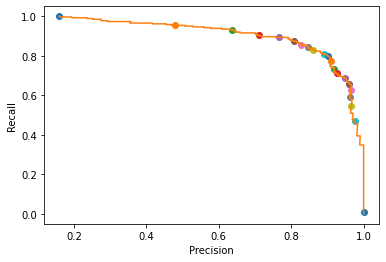

[-1  1]
              precision    recall  f1-score   support

          -1       0.98      0.98      0.98      1952
           1       0.86      0.83      0.85       261

    accuracy                           0.96      2213
   macro avg       0.92      0.91      0.91      2213
weighted avg       0.96      0.96      0.96      2213

 ----- list1 -----
              precision    recall  f1-score   support

          -1       1.00      0.74      0.85      1952
           1       0.33      0.97      0.49       261

    accuracy                           0.77      2213
   macro avg       0.66      0.86      0.67      2213
weighted avg       0.92      0.77      0.81      2213

[[1439  513]
 [   7  254]]



In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
import pprint as pp
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

def show_confusion_matrix(svmclf, X_test, y_test, params):
  y_pred = svmclf.predict(X_test) 
  y_values = svmclf.decision_function(X_test)
  # ad-hoc
  # class 0なら、minus方面、class 1なら plus方面
  cls_idx_dict = {}
  threshhold = params['threshhold']
  print(svmclf.classes_)
  for idx, key in enumerate(svmclf.classes_):
    # cls_idx_dict[key] = idx
    cls_idx_dict[idx] = key

  list1 = []
  # {-1, 1}
  for value in y_values:
      if value < threshhold:
        cls = cls_idx_dict[0]
        list1.append(cls)
      else:
        cls = cls_idx_dict[1]
        list1.append(cls)
  
  print(classification_report(y_test, y_pred))
  print(" ----- list1 -----")
  print(classification_report(y_test, list1))
  cm = metrics.confusion_matrix(y_test, list1)
  print(cm)
  print()

def traverse_data_split1(key, X, y):
    skf = StratifiedKFold(n_splits=2, shuffle=True, random_state=0)
    for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
      print(f'Start: fold {i+1}')
      X_train, y_train = X[train_index, :], y[train_index]
      X_valid, y_valid = X[valid_index, :], y[valid_index]

      tuned_parameters = [
        {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      ]
      gogo_grid_search_SVM(X_train, y_train, X_valid, y_valid, tuned_parameters)

def traverse_data_split(key, X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    tuned_parameters = [
           #{'C': [1, 10, 100, 1000], 'kernel': ['linear']},  
           {'C': [1], 'kernel': ['linear']},
    ]
    gogo_grid_search_SVM(X_train, y_train, X_test, y_test, tuned_parameters)

def gogo_grid_search_SVM(X_train, y_train, X_test, y_test, tuned_parameters):
  score = 'recall'
  #clf = GridSearchCV( 
  #    SVC(), # 識別器
  #    tuned_parameters, # 最適化したいパラメータセット 
  #    cv=5, # 交差検定の回数
  #    scoring='%s_weighted' % score ) 
  clf = GridSearchCV( 
      SVC(probability=True), # 識別器
      tuned_parameters, # 最適化したいパラメータセット 
      cv=5, # 交差検定の回数
      verbose=2,
      refit=True,
      scoring='%s_weighted' % score ) 
  clf.fit(X_train, y_train)
      
  pp.pprint(clf.cv_results_)
  pp.pprint(clf.best_params_)

  print("# Tuning hyper-parameters for %s" % score)
  print()
  print("Best parameters set found on development set: %s" % clf.best_params_)
  print()

  # テストデータセットでの分類精度を表示
  print("The scores are computed on the full evaluation set.")
  print()

  best_estimator = clf.best_estimator_
  # y_true, y_pred = y_test, clf.predict(X_test)
  # print(classification_report(y_true, y_pred))
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test,  best_estimator.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      print([precision[close_point], recall[close_point], threshold[close_point]])
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

  # confusion matrix を表示して、抜け漏れ0を実感
  params1 = {'threshhold': -1.5}
  show_confusion_matrix(best_estimator, X_test, y_test, params1)

key = "svm"
traverse_data_split(key, X, y)

# tuned_parameters1 = [
#    {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
#    {'C': [1, 10, 100, 1000], 'kernel': ['rbf'], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['poly'], 'degree': [2, 3, 4], 'gamma': [0.001, 0.0001]},
#    {'C': [1, 10, 100, 1000], 'kernel': ['sigmoid'], 'gamma': [0.001, 0.0001]}
#    ]

スレッシュホールドによる出力制限を行います。
斜陽文を絶対逃さないマシンを作る。困ったら斜陽にしよう。

Start: fold 1


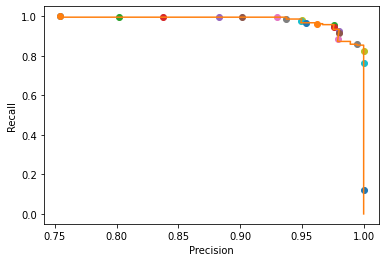

Start: fold 2


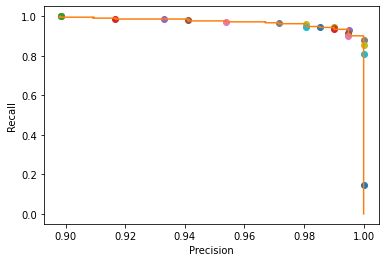

Start: fold 3


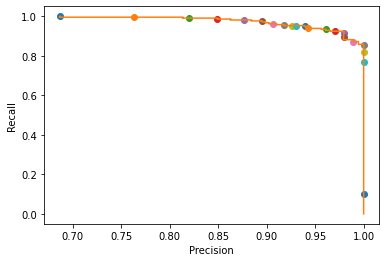

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve

# y = df.cls.values
# print(y)
y = df.label.values
accs_dict = {}
elapsed_times_dict = {}
vector_times_dict = {}

def gogo_recall100Sub(X_train, X_test, y_train, y_test, params) -> None:
  START_TIME = time.time()
   
  # for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
  #  print(f'Start: fold {i+1}')
  #  X_train, y_train = X[train_index, :], y[train_index]
  #  X_valid, y_valid = X[valid_index, :], y[valid_index]

  svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  y_pred = svmclf.predict(X_test)
  y_values = svmclf.decision_function(X_test)
  # ad-hoc
  # class 0なら、minus方面、class 1なら plus方面
  cls_idx_dict = {}
  threshhold = params['threshhold']
  print(svmclf.classes_)
  for idx, key in enumerate(svmclf.classes_):
    # cls_idx_dict[key] = idx
    cls_idx_dict[idx] = key

  list1 = []
  for value in y_values:
      if value < threshhold:
        cls = cls_idx_dict[0]
        list1.append(cls)
      else:
        cls = cls_idx_dict[1]
        list1.append(cls)
  
  
  print(classification_report(y_test, y_pred))
  print(" ----- list1 -----")
  print(classification_report(y_test, list1))
  cm = metrics.confusion_matrix(y_test, list1)
  print(cm)
  print()

  elapsed_time = time.time() - START_TIME
  print(f'Elapsed time is {elapsed_time}')
  # return accuracies, elapsed_time


def gogo_recall100(X, y, params) -> None:
  START_TIME = time.time()
  skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
  accuracies = {}
  for i, (train_index, valid_index) in enumerate(skf.split(X, y)):
    print(f'Start: fold {i+1}')
    X_train, y_train = X[train_index, :], y[train_index]
    X_test, y_test = X[valid_index, :], y[valid_index]

    #gogo_recall100Sub(X_train, X_test, y_train, y_test, params) -> None:
    gogo_recall100Sub2(X_train, X_test, y_train, y_test, params)

params = {'threshhold': 0.7}

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import precision_recall_curve

def gogo_recall100Sub2(X_train, X_test, y_train, y_test, params) -> None:

  svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  y_pred = svmclf.predict_proba(X_test)

  # ある閾値の時の適合率、再現率の値を取得
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test, svmclf.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()
vector_time = time.time() - START_TIME
vector_times_dict['bow'] = vector_time

gogo_recall100(X, y, params)

Recall-Precision 曲線を描いておしまい

# LightGBM編

まずは学習データを用いてLightGBMで分類する

1. パラメータチューニングの仕組みを学ぶ
2. スコアを見る
3. PR曲線を描いてみる

In [67]:
!pip install lightgbm
!pip install optuna
!pip install bayesian-optimization
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=65681a291e19fb197faa83c562f6099f35572209794b9538074a51a3211a13a5
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [68]:
!pip install seaborn_analyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 59 kB 2.5 MB/s 
     |████████████████████████████████| 2.0 MB 9.4 MB/s 
  Attempting uninstall: lightgbm
    Found existing installation: lightgbm 2.2.3
    Uninstalling lightgbm-2.2.3:
      Successfully uninstalled lightgbm-2.2.3


In [69]:
from sklearn.metrics import precision_recall_curve

def gogo_recall100Sub2(X_train, X_test, y_train, y_test, params) -> None:

  model.set_params(**best_params1)
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  model.fit(X_train, y_train)
  
  y_pred = svmclf.predict_proba(X_test)

  # ある閾値の時の適合率、再現率の値を取得
  # svmclf = svm.SVC(C = 1.0, kernel = 'linear', probability=True)
  # train_docはベクトル化した文書のリスト
  # labelsは文書のカテゴリのリスト
  svmclf.fit(X_train, y_train)
  
  # ある閾値の時の適合率、再現率の値を取得
  precision, recall, threshold = precision_recall_curve(y_test, svmclf.predict_proba(X_test)[:, 1])
  # 0から1まで0.05刻みで○をプロット
  for i in range(21):
      close_point = np.argmin(np.abs(threshold - (i * 0.05)))
      plt.plot(precision[close_point], recall[close_point], 'o')

  # 適合率-再現率曲線
  plt.plot(precision, recall)
  plt.xlabel('Precision')
  plt.ylabel('Recall')

  plt.show()

vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()
vector_time = time.time() - START_TIME
vector_times_dict['bow'] = vector_time

gogo_recall100(X, y, params)

AttributeError: ignored

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size= 0.7, random_state = 0)

import lightgbm as lgb
from sklearn.metrics import classification_report

train_data = lgb.Dataset(X_train, label=y_train)
eval_data = lgb.Dataset(X_test, label=y_test)

params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'random_state':0
    }

gbm = lgb.train(
    params,
    train_data,
    valid_sets=eval_data,
)
y_preds = gbm.predict(X_test)

from sklearn import metrics
import matplotlib.pyplot as plt
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_preds)
auc = metrics.auc(fpr, tpr)
print(auc)

plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.plot(np.linspace(1, 0, len(fpr)), np.linspace(1, 0, len(fpr)), label='Random ROC curve (area = %.2f)'%0.5, linestyle = '--', color = 'gray')

plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)
plt.show()

precision, recall, thresholds = metrics.precision_recall_curve(y_test, y_preds)

auc = metrics.auc(recall, precision)
print(auc)

plt.plot(recall, precision, label='PR curve (area = %.2f)'%auc)
plt.legend()
plt.title('PR curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.show()


In [ ]:
from math import e
# from seaborn_analyzer import regplot
from lightgbm import LGBMRegressor
from sklearn.model_selection import KFold

import lightgbm as lgb
import pandas as pd
import time

# df_osaka = pd.read_csv(f'./sample_data/osaka_metropolis_english.csv')
OBJECTIVE_VARIALBLE = 'label'  # 目的変数
USE_EXPLANATORY = ['wakati_text']  # 説明変数
y = df[OBJECTIVE_VARIALBLE].values  # 目的変数をndarray化
# X = df[USE_EXPLANATORY].values  # 説明変数をndarray化
# データを表示
# df[USE_EXPLANATORY + [OBJECTIVE_VARIALBLE]]
vectorizer = CountVectorizer(token_pattern=u'(?u)\\b\\w+\\b')
START_TIME = time.time()
X = vectorizer.fit_transform(df.wakati_text.values)
X = X.toarray()

# 乱数シード
seed = 42
# モデル作成
params1 = { 'boosting_type': 'gbdt', 
              'objective': 'binary',
              'random_state': seed, 
              'n_estimators': 10000 }

# model = lgb.LGBMClassifier(params1)  # チューニング前のモデル
model = lgb.LGBMClassifier(boosting_type='gbdt', objective='binary',
                      random_state=seed, n_estimators=10000)
# 学習時fitパラメータ指定
fit_params = {'callbacks': [lgb.early_stopping(
                  stopping_rounds=10, # 学習時、評価指標がこの回数連続で改善しなくなった時点でストップ
                  verbose=0)],  # 学習中のコマンドライン出力
              'eval_metric': 'recall',  # early_stopping_roundsの評価指標
              'eval_set': [(X, y)]  # early_stopping_roundsの評価指標算出用データ
              }

# クロスバリデーションして決定境界を可視化
cv = KFold(n_splits=3, shuffle=True, random_state=seed) 

from sklearn.model_selection import cross_val_score
# scoring = 'neg_root_mean_squared_error'  # 評価指標をMSEに指定
scoring = 'recall'  # 評価指標をRecallに指定
# クロスバリデーションで評価指標算出
scores = cross_val_score(model, X, y, cv=cv,
                         scoring=scoring, n_jobs=-1, fit_params=fit_params)
print(f'scores={scores}')
print(f'average_score={np.mean(scores)}')


In [ ]:
!pip install matplotlib==3.1.3

In [ ]:
import optuna
start = time.time()
# ベイズ最適化時の評価指標算出メソッド
def bayes_objective(trial):
    params = {
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0001, 0.1, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0001, 0.1, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 6),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 0, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 0, 10)
    }
    # モデルにパラメータ適用
    model.set_params(**params)
    # cross_val_scoreでクロスバリデーション
    scores = cross_val_score(model, X, y, cv=cv,
                             scoring=scoring, fit_params=fit_params, n_jobs=-1)
    val = scores.mean()
    return val

# ベイズ最適化を実行
study = optuna.create_study(direction='maximize',
                            sampler=optuna.samplers.TPESampler(seed=seed))
study.optimize(bayes_objective, n_trials=400)

# 最適パラメータの表示と保持
best_params1 = study.best_trial.params
best_score1 = study.best_trial.value
print(f'最適パラメータ {best_params1}\nスコア {best_score1}')
print(f'所要時間{time.time() - start}秒')